In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from myfunctions import set_importer, scores
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV, RFE
from sklearn.metrics import accuracy_score, precision_score, recall_score

pd.set_option('display.max_columns', None)

sns.set_style("whitegrid")
%matplotlib inline

# setting font size for all plots
font = {'size'   : 16}

plt.rc('font', **font)

In [2]:
# import X_train_encoded, X_test_encoded, y_train and y_test
X_train = set_importer('../analysis-dfs/X_train_prepared.csv')
X_test = set_importer('../analysis-dfs/X_test_prepared.csv')

y_train = set_importer('../analysis-dfs/y_train_prepared.csv', y=True)
y_test = set_importer('../analysis-dfs/y_test_prepared.csv', y=True)

display(X_train.shape)
X_train.head(10)

(29852, 47)

,gps_height,longitude,latitude,region_code,district_code,population,permit,construction_year,basin_lake nyasa,basin_lake rukwa,basin_lake tanganyika,basin_lake victoria,basin_pangani,basin_rufiji,basin_ruvuma / southern coast,basin_wami / ruvu,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group,payment_other,payment_pay annually,payment_pay monthly,payment_pay per bucket,payment_pay when scheme fails,payment_unknown,quality_group_fluoride,quality_group_good,quality_group_milky,quality_group_salty,quality_group_unknown,quantity_group_enough,quantity_group_insufficient,quantity_group_seasonal,quantity_group_unknown,source_class_surface,source_class_unknown,waterpoint_type_group_communal standpipe,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
0,-0.368039,1.842721,-1.698549,-0.386675,-0.148733,1.302765,0.694530,0.835788,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,-0.896969,-0.232595,-1.097460,-0.217496,0.167400,-0.687158,0.694530,-1.180012,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0
2,-0.896969,-0.150773,-1.068236,-0.217496,0.167400,-0.687158,0.694530,-1.180012,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0
3,-0.705621,1.215680,-0.570298,-0.612247,-0.359489,0.970002,0.694530,0.851044,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
4,0.983844,-0.420747,1.107311,0.233648,-0.148733,1.302765,-1.439823,0.862232,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1
5,0.923173,-0.683206,1.171351,0.177255,-0.464866,2.633817,0.694530,0.850027,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
6,-0.896969,-1.234213,1.325048,0.120862,-0.359489,-0.687158,0.694530,-1.180012,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
7,-0.896969,0.044576,1.812261,0.064469,-0.464866,-0.687158,-1.439823,-1.180012,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
8,0.725602,0.150197,-1.762897,-0.330282,-0.254111,-0.361050,0.694530,0.843925,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
9,2.396399,-0.289534,-1.153023,-0.273889,-0.254111,-0.687158,-1.439823,0.827652,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0


# Modelling

In [3]:
vanilla_logreg = LogisticRegression(solver='saga', random_state=21) # using saga because this is a very big data set
vanilla_logreg.fit(X_train, y_train)

y_preds_test = vanilla_logreg.predict(X_test)
y_probs_test = vanilla_logreg.predict_proba(X_test)[:, 1]

In [4]:
# printing the scores
print('Vanilla scores')
scores(y_test, y_preds_test, y_probs_test)

Vanilla scores
The precision score is:	 0.9223942598187311
The recall score is:	 0.7554902567274977
The accuracy score is:	 0.7387883556254917
The log loss is:	 0.5256986425167508
The auc is:	 0.7583721748776091


# Optimizing the model

## Feature Selection

Using RFECV which perform RFE in a cross-validation loop to find the best features.

In [5]:
logreg = LogisticRegression(solver='saga', random_state=21)

rfecv = RFECV(logreg, scoring='neg_log_loss')
rfecv.fit(X_train, y_train)

len(rfecv.cv_results_['mean_test_score'])

47

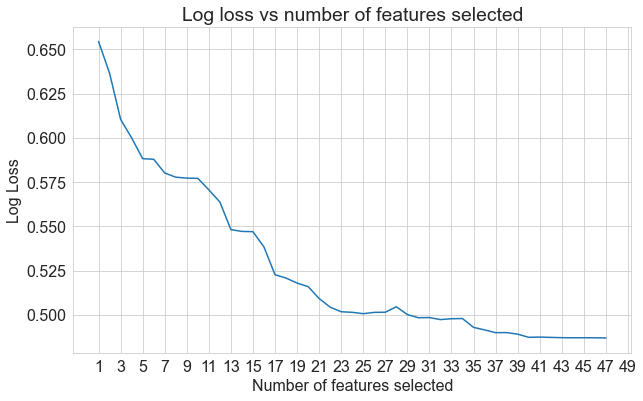

In [6]:
# plotting the results
plt.figure(figsize=(10,6))
plt.plot(np.arange(1, len(rfecv.cv_results_['mean_test_score'])+1), -rfecv.cv_results_['mean_test_score'])
plt.ylabel('Log Loss')
plt.xlabel('Number of features selected')
plt.xticks(np.arange(1, 51, 2))
plt.title('Log loss vs number of features selected')
plt.show()

The log loss decrease with the increase in features. The log loss is mininum when all features are selected. Hence the vanila model is still the best

## Evaluating the Model using cross_val_score

In [7]:
cv_log_loss = cross_val_score(vanilla_logreg, X_train, y_train, cv=10, scoring='neg_log_loss')
cv_accuracy_score = cross_val_score(vanilla_logreg, X_train, y_train, cv=10, scoring='accuracy')

In [8]:
print('K-fold cross-validation results')
print('The mean log loss is:\t', -cv_log_loss.mean())
print('The mean accuracy score is:\t', cv_accuracy_score.mean())

K-fold cross-validation results
The mean log loss is:	 0.47585236347555127
The mean accuracy score is:	 0.7871230791151561


With cross validation the vanilla model seems to be doing better even. Hence will still stick with it as been the best

## Using Grid Search I will locate the best parameters

In [60]:
param_grid = {
    'C': [1, 1e5],
    'solver': ['sag', 'saga'],
    'penalty':  ['elasticnet', 'l1', 'l2'],
    'max_iter': [3000, 5000]
}


In [61]:
logreg = LogisticRegression(random_state=21)
logreg_gridcv = GridSearchCV(logreg, param_grid=param_grid, scoring='neg_log_loss', cv=5)
logreg_gridcv.fit(X_train, y_train)

logreg_gridcv_results = logreg_gridcv.cv_results_

/home/iain/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/iain/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/iain/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/iain/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 61, in _check_solver
    raise Valu

In [62]:
logreg_gridcv.best_params_

{'C': 1, 'max_iter': 3000, 'penalty': 'l2', 'solver': 'sag'}